In [1]:
import time
import os
from os import listdir
from os.path import join, isfile
import glob
import numpy as np
import numpy.matlib
import pandas as pd
import pyedflib
from scipy.signal import find_peaks_cwt, welch
from scipy.signal import decimate
from datetime import timedelta
from mne.filter import filter_data

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, hilbert, chirp
from scipy import signal
from scipy.fft import fft, ifft


# Data information

In [2]:
# csv file 
#data = pd.read_csv('data/EMA_data.csv')
dataPre = pd.read_csv('data/bagData/Labels_all.csv')

In [3]:
paths = glob.glob("/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/npy_csv/*.npy")

In [4]:
csv_paths = glob.glob("/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/npy_csv/*.csv")

In [5]:
appended_data = []

for i in csv_paths:
    df = pd.read_csv(i)
    appended_data.append(df)
    
appended_data = pd.concat(appended_data)
#appended_data.to_csv('concatdf_all_files.csv',index=False)

In [6]:
appended_data.head()

,ID,beep_time_start,beep_time_end,mood_well,mood_down,mood_fright,mood_tense,phy_sleepy,phy_tired,mood_cheerf,...,mor_tired_phys,mor_tired_ment,eve_many_offs,eve_long_offs,eve_walk_well,eve_clothing,eve_eat_well,eve_personalcare,eve_household,eve_tired
0,110011,2018-11-08 08:47:11,2018-11-08 08:49:00,6,2,1,1,1,1,6.0,...,3.0,2.0,1.0,1.0,6.0,5.0,6.0,6.0,6.0,5.0
1,110011,2018-11-08 11:11:11,2018-11-08 11:12:24,6,1,1,1,1,1,2.0,...,3.0,2.0,1.0,1.0,6.0,5.0,6.0,6.0,6.0,5.0
2,110011,2018-11-08 13:42:21,2018-11-08 13:43:42,6,1,1,3,2,2,7.0,...,3.0,2.0,1.0,1.0,6.0,5.0,6.0,6.0,6.0,5.0
3,110011,2018-11-08 14:52:54,2018-11-08 15:16:29,6,5,2,2,2,2,1.0,...,3.0,2.0,1.0,1.0,6.0,5.0,6.0,6.0,6.0,5.0
4,110011,2018-11-08 17:34:07,2018-11-08 17:35:38,7,1,1,1,2,2,1.0,...,3.0,2.0,1.0,1.0,6.0,5.0,6.0,6.0,6.0,5.0


## The attributes recorded in the data

In [7]:
appended_data.columns

Index(['ID', 'beep_time_start', 'beep_time_end', 'mood_well', 'mood_down',
       'mood_fright', 'mood_tense', 'phy_sleepy', 'phy_tired', 'mood_cheerf',
       'mood_relax', 'thou_concent', 'pat_hallu', 'loc_where', 'soc_who',
       'soc_who02', 'soc_who03', 'act_what', 'act_what02', 'act_what03',
       'act_problemless', 'mobility_well', 'sit_still', 'speech_well',
       'walk_well', 'tremor', 'slowness', 'stiffness', 'muscle_tension',
       'dyskinesia', 'sanpar_onoff', 'sanpar_medic', 'beep_disturb',
       'mor_sleptwell', 'mor_often_awake', 'mor_rested', 'mor_tired_phys',
       'mor_tired_ment', 'eve_many_offs', 'eve_long_offs', 'eve_walk_well',
       'eve_clothing', 'eve_eat_well', 'eve_personalcare', 'eve_household',
       'eve_tired'],
      dtype='object')

## Number of answered questionaires pr person


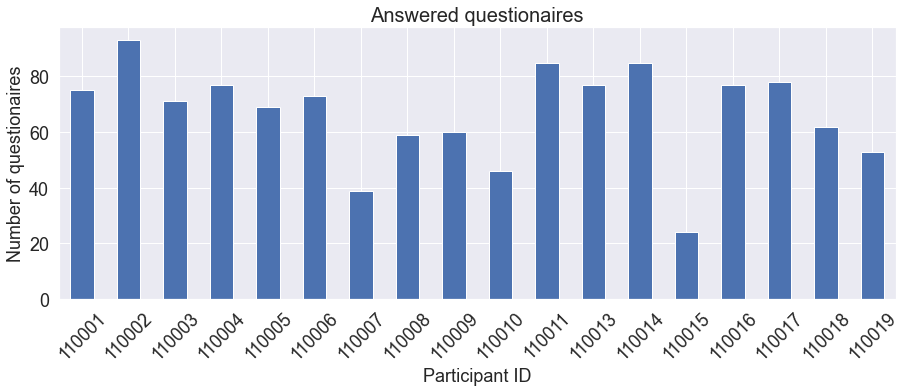

In [165]:
fig=plt.figure(figsize=(15,5))
appended_data.ID.value_counts().sort_index().plot(kind='bar',fontsize = 18)
plt.ylabel('Number of questionaires',fontsize = 18)
plt.xlabel('Participant ID',fontsize = 18)
plt.xticks(rotation=45)
plt.title('Answered questionaires',fontsize=20)
plt.show()
fig.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/P_ID.png',bbox_inches='tight')

In [9]:
ctab = pd.crosstab(appended_data['ID'], appended_data['tremor'], values=appended_data['tremor'], aggfunc='count').T

In [10]:
ctab

ID,110001,110002,110003,110004,110005,110006,110007,110008,110009,110010,110011,110013,110014,110015,110016,110017,110018,110019
tremor,,,,,,,,,,,,,,,,,,
1.0,72.0,3.0,71.0,72.0,30.0,NaN,6.0,56.0,60.0,44.0,10.0,31.0,62.0,1.0,NaN,NaN,1.0,12.0
2.0,NaN,65.0,NaN,3.0,27.0,2.0,4.0,2.0,NaN,NaN,36.0,34.0,9.0,12.0,42.0,3.0,10.0,27.0
3.0,1.0,20.0,NaN,1.0,4.0,3.0,1.0,NaN,NaN,NaN,31.0,8.0,2.0,6.0,18.0,64.0,11.0,7.0
4.0,2.0,4.0,NaN,1.0,1.0,59.0,8.0,NaN,NaN,1.0,6.0,3.0,2.0,4.0,7.0,8.0,11.0,4.0
5.0,NaN,1.0,NaN,NaN,2.0,4.0,14.0,1.0,NaN,1.0,1.0,1.0,4.0,1.0,9.0,2.0,15.0,3.0
6.0,NaN,NaN,NaN,NaN,2.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,11.0,NaN
7.0,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN


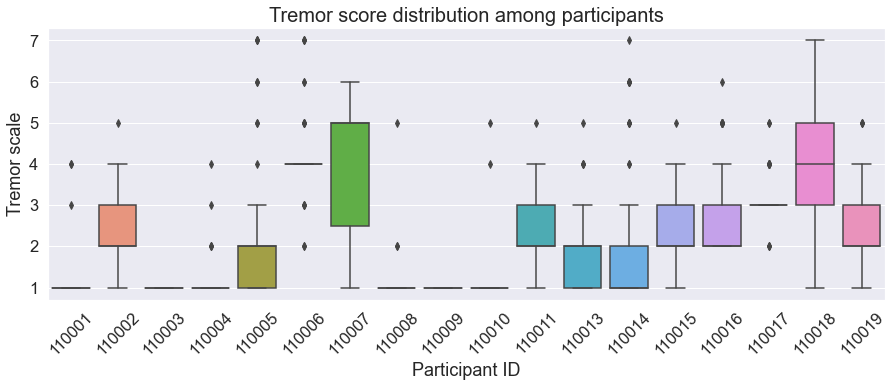

In [186]:
fig=plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.boxplot(x="ID",  y="tremor", data=appended_data)
sns.set_context("paper", rc={"font.size":40,"axes.titlesize":10,"axes.labelsize":10})   
plt.title('Tremor score distribution among participants',fontsize=20)
plt.xlabel('Participant ID',fontsize=18)
plt.ylabel('Tremor scale',fontsize=18)
plt.xticks(rotation=45)
plt.show()
fig.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/tremorExpPD.png',bbox_inches='tight')

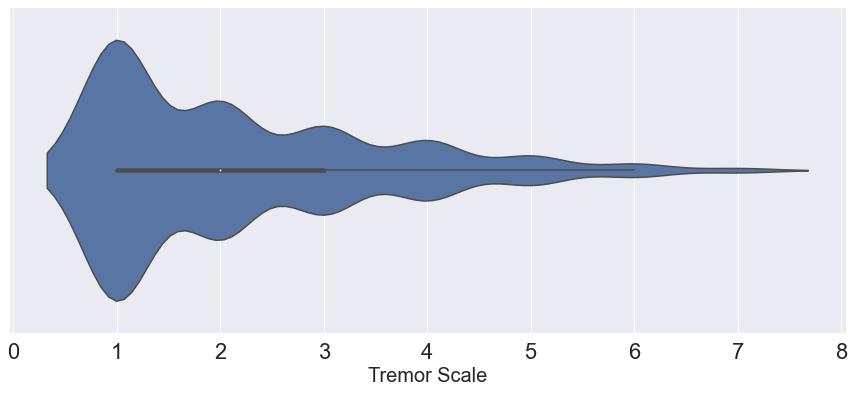

In [167]:
fig=plt.figure(figsize=(15,6))
sns.set(font_scale=2)  
#ax = sns.swarmplot(x=appended_data["tremor"])
ax = sns.violinplot(x=appended_data["tremor"])
plt.xlabel('Tremor Scale',fontsize=20);
fig.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/Distribution.png',bbox_inches='tight')

In [126]:
appended_data['binary'] = appended_data.apply(lambda x: 1 if x['tremor']>1 else 0 ,axis=1)

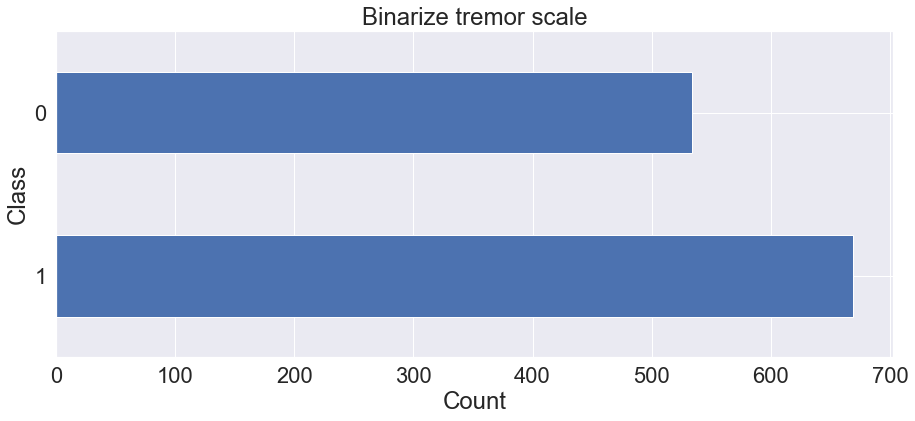

In [166]:
fig=plt.figure(figsize=(15,6))
appended_data['binary'].value_counts().plot(kind='barh')
plt.title('Binarize tremor scale')
plt.xlabel('Count')
plt.ylabel('Class')
fig.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/binary.png',bbox_inches='tight')

In [160]:
print(appended_data['binary'].value_counts()[0])
print(appended_data['binary'].value_counts()[0]/appended_data['binary'].shape)

534
[0.44389027]


In [161]:
print(appended_data['binary'].value_counts()[1])
print(appended_data['binary'].value_counts()[1]/appended_data['binary'].shape)

669
[0.55610973]


In [13]:
appended_data['timepoint'] =  pd.to_datetime(appended_data['beep_time_start'])
# 2018-11-08 08:47:11
appended_data['hour']=pd.DatetimeIndex(appended_data['timepoint']).hour

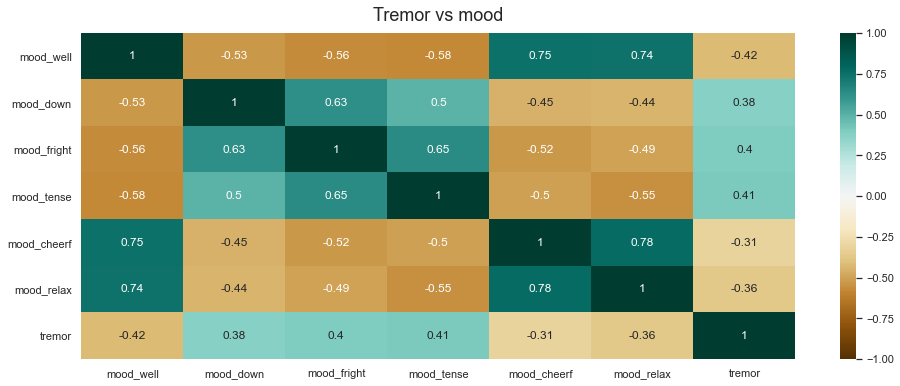

In [14]:
subset=appended_data[['mood_well', 'mood_down',
       'mood_fright', 'mood_tense', 'mood_cheerf',
       'mood_relax','tremor']]
plt.figure(figsize=(16, 6))
sns.set(font_scale=1)  

heatmap = sns.heatmap(subset.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Tremor vs mood', fontdict={'fontsize':18}, pad=12);

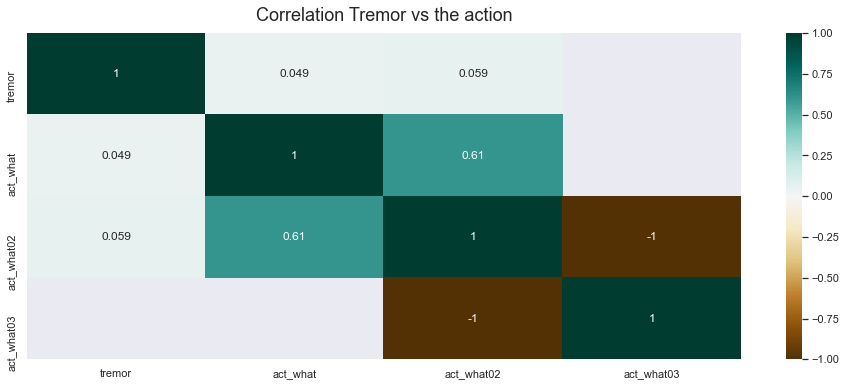

In [15]:
subset=appended_data[['tremor','act_what', 'act_what02', 'act_what03']]
plt.figure(figsize=(16, 6))
sns.set(font_scale=1)  

heatmap = sns.heatmap(subset.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Tremor vs the action', fontdict={'fontsize':18}, pad=12);

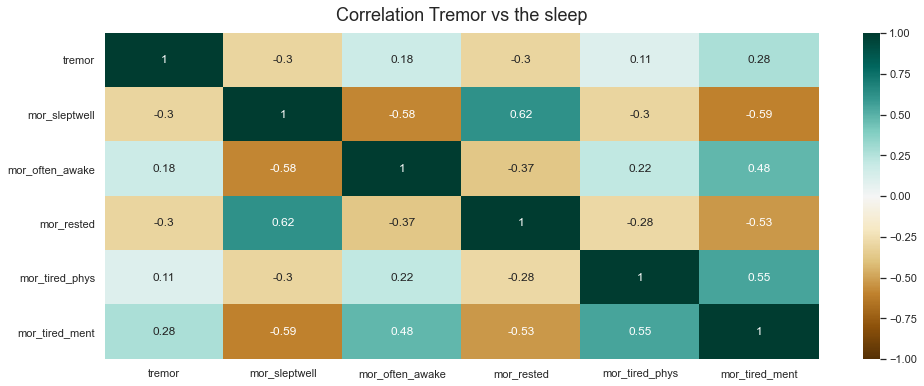

In [16]:
subset=appended_data[['tremor','mor_sleptwell', 'mor_often_awake', 'mor_rested', 'mor_tired_phys',
       'mor_tired_ment']]
plt.figure(figsize=(16, 6))
sns.set(font_scale=1)  

heatmap = sns.heatmap(subset.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Tremor vs the sleep', fontdict={'fontsize':18}, pad=12);

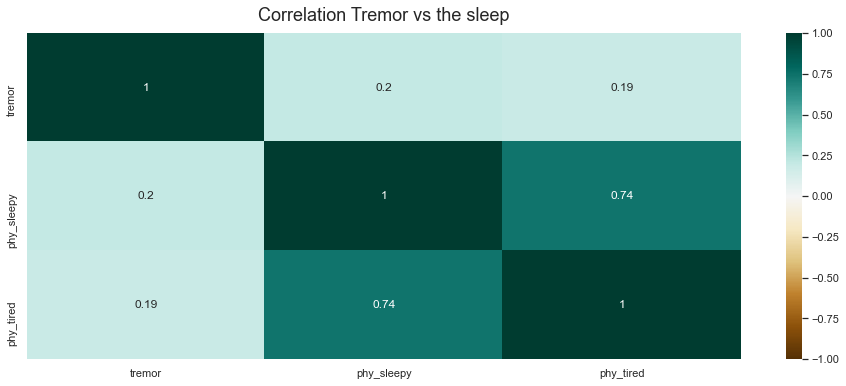

In [17]:
subset=appended_data[['tremor','phy_sleepy', 'phy_tired']]
plt.figure(figsize=(16, 6))
sns.set(font_scale=1)  

heatmap = sns.heatmap(subset.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Tremor vs the sleep', fontdict={'fontsize':18}, pad=12);

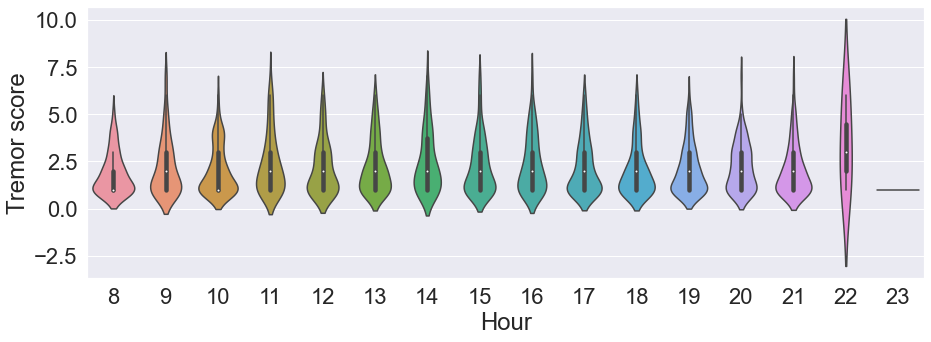

In [18]:
fig=plt.figure(figsize=(15,5))
sns.set(font_scale=2)  
#ax = sns.swarmplot(x=appended_data["tremor"])
ax = sns.violinplot(y=appended_data["tremor"], x=appended_data["hour"] )
plt.ylabel('Tremor score')
plt.xlabel('Hour')
plt.show()

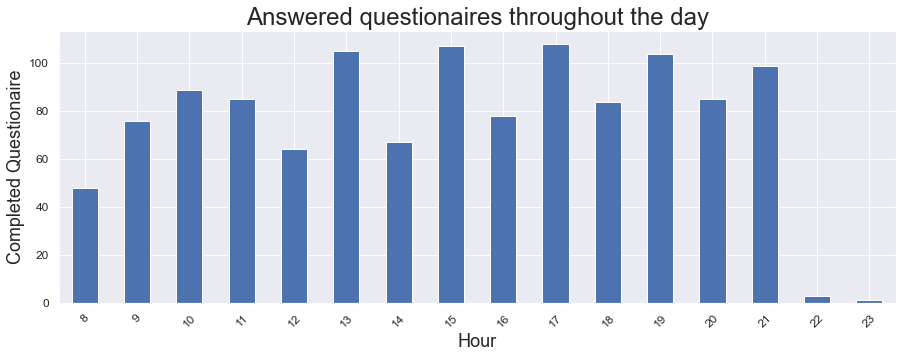

In [163]:
fig=plt.figure(figsize=(15,5))
appended_data.hour.value_counts().sort_index().plot(kind='bar',fontsize = 12)
plt.ylabel('Completed Questionaire',fontsize = 18)
plt.xlabel('Hour',fontsize = 18)
plt.xticks(rotation=45)
plt.title('Answered questionaires throughout the day')
plt.show()
fig.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/HourofDay.png')

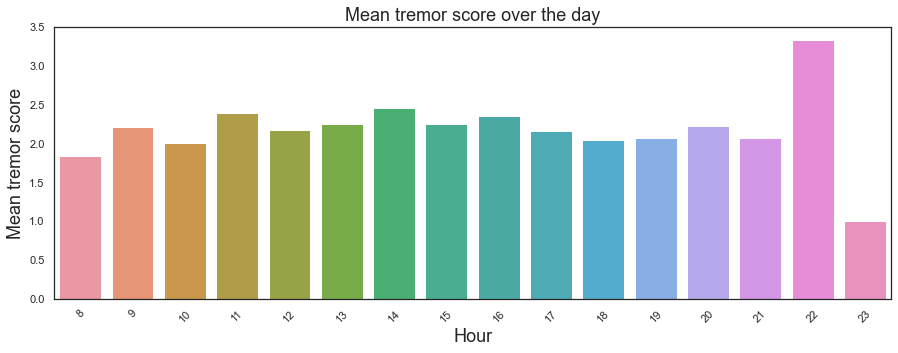

In [20]:
sub = appended_data.groupby('hour', as_index=False)['tremor'].mean().sort_values(by='hour')

fig=plt.figure(figsize=(15,5))
sns.set(font_scale=2)  
sns.set(style="white")
ax = sns.barplot(x='hour', y='tremor', data=sub)
plt.ylabel('Mean tremor score',fontsize = 18)
plt.xlabel('Hour',fontsize = 18)
plt.title('Mean tremor score over the day',fontsize = 18)
plt.xticks(rotation=45)
plt.show()

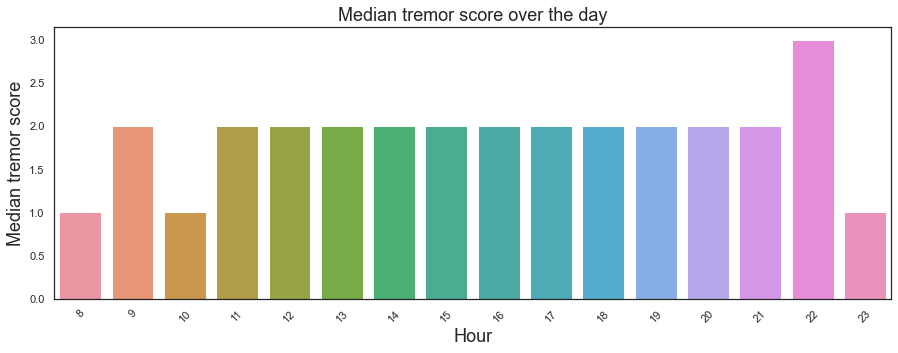

In [21]:
sub = appended_data.groupby('hour', as_index=False)['tremor'].median().sort_values(by='hour')

fig=plt.figure(figsize=(15,5))
sns.set(font_scale=2)  
sns.set(style="white")
ax = sns.barplot(x='hour', y='tremor', data=sub)
plt.ylabel('Median tremor score',fontsize = 18)
plt.xlabel('Hour',fontsize = 18)
plt.title('Median tremor score over the day',fontsize = 18)
plt.xticks(rotation=45)
plt.show()

In [22]:
nighttime22=appended_data[appended_data['hour']==22]

In [23]:
nighttime22

,ID,beep_time_start,beep_time_end,mood_well,mood_down,mood_fright,mood_tense,phy_sleepy,phy_tired,mood_cheerf,...,eve_many_offs,eve_long_offs,eve_walk_well,eve_clothing,eve_eat_well,eve_personalcare,eve_household,eve_tired,timepoint,hour
71,110011,2018-11-19 22:03:29,2018-11-19 22:04:14,6,1,1,1,2,3,6.0,...,1.0,1.0,6.0,6.0,7.0,7.0,6.0,3.0,2018-11-19 22:03:29,22
15,110013,2018-11-26 22:00:58,2018-11-26 22:04:05,5,1,1,2,4,5,6.0,...,1.0,1.0,5.0,6.0,7.0,7.0,6.0,2.0,2018-11-26 22:00:58,22
17,110005,2018-10-04 22:01:18,2018-10-04 22:03:18,6,1,1,6,2,5,4.0,...,1.0,1.0,6.0,6.0,6.0,6.0,6.0,4.0,2018-10-04 22:01:18,22


# Feature analysis 

In [24]:
paths = glob.glob("/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_OnlineData/data/npy_csv/*.npy")

In [25]:
PATH_featureFiles = glob.glob('data/feature_bag_data/*.npy') 

In [26]:
dataPre = pd.read_csv('data/bagData/Labels_all.csv')

In [27]:
np.load(paths[0]).shape

(75, 90000, 18)

In [28]:
np.load(PATH_featureFiles[0]).shape

(180, 5, 12)

### Function to plot the spectrogram and filterings

In [29]:
def spectrogram(f_accXL,f_accYL,f_accZL,f_accXR,f_accYR,f_accZR):

    NFFT = 128 
    noverlap = int(0.50*NFFT)
    
    sr = 100 
    
    fig = plt.figure(figsize=(20,10))
    plt.subplot(2,3,1)
    powerSpectrumXL, freqenciesFoundXL, _ , _  =plt.specgram(f_accXL, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), cmap='gist_rainbow')
    plt.axhline(y=3.5, color='r', linestyle='-')
    plt.axhline(y=7.5, color='r', linestyle='-')
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency')
    plt.title('Accelerometer Left X')
    plt.colorbar()

    plt.subplot(2,3,2)
    powerSpectrumYL, freqenciesFoundYL, _ , _  =plt.specgram(f_accYL, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), cmap='gist_rainbow')
    plt.axhline(y=3.5, color='r', linestyle='-')
    plt.axhline(y=7.5, color='r', linestyle='-')
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency')
    plt.title('Accelerometer Left Y')
    plt.colorbar()

    plt.subplot(2,3,3)
    powerSpectrumZL, freqenciesFoundZL, _ , _  = plt.specgram(f_accZL, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), cmap='gist_rainbow')
    plt.axhline(y=3.5, color='r', linestyle='-')
    plt.axhline(y=7.5, color='r', linestyle='-')
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency')
    plt.title('Accelerometer Left Z')
    plt.colorbar()

    plt.subplot(2,3,4)
    powerSpectrumXR, freqenciesFoundXR, _ , _ = plt.specgram(f_accXR, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), cmap='gist_rainbow')
    plt.axhline(y=3.5, color='r', linestyle='-')
    plt.axhline(y=7.5, color='r', linestyle='-')
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency')
    plt.title('Accelerometer Right X')
    plt.colorbar()

    plt.subplot(2,3,5)
    powerSpectrumYR, freqenciesFoundYR, _, _  = plt.specgram(f_accYR, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), 
                 cmap='gist_rainbow')
    plt.axhline(y=3.5, color='r', linestyle='-')
    plt.axhline(y=7.5, color='r', linestyle='-')
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency')
    plt.title('Accelerometer Right Y')
    plt.colorbar()

    plt.subplot(2,3,6)
    powerSpectrumZR, freqenciesFoundZR,  _, _= plt.specgram(f_accZR, Fs=sr, NFFT=NFFT, noverlap=noverlap, window=signal.gaussian(NFFT,std=12), 
                 cmap='gist_rainbow')
    plt.axhline(y=3.5, color='r', linestyle='-')
    plt.axhline(y=7.5, color='r', linestyle='-')
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency')
    plt.title('Accelerometer Right Z')
    plt.colorbar()
    plt.show()

In [30]:


from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=8):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def highpass(data,order=5,highpassWn = 1,fs=100):
    b, a = signal.butter(order, highpassWn, 'highpass',fs = fs) 
    outputSignal = signal.filtfilt(b, a, data)
    return outputSignal



In [31]:
def getSpectrogram(data,nESM):
    f_accXL = highpass(data[nESM,:,0])
    f_accYL = highpass(data[nESM,:,1])
    f_accZL = highpass(data[nESM,:,2])

    f_accXR = highpass(data[nESM,:,6]) 
    f_accYR = highpass(data[nESM,:,7]) 
    f_accZR = highpass(data[nESM,:,8]) 
    
    spectrogram(f_accXL,f_accYL,f_accZL,f_accXR,f_accYR,f_accZR)

#### Call the function to get the spectrogram: 

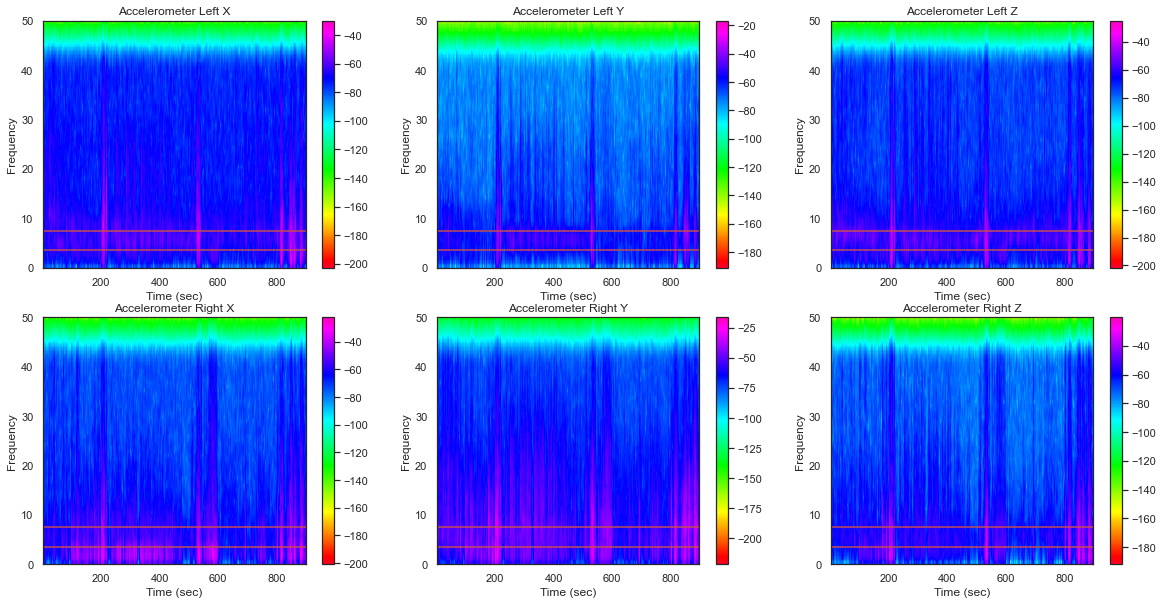

Not tremor
110001


In [42]:
pathIdx = 0 
data = np.load(paths[pathIdx]).astype(np.float64)
nESM = 13
getSpectrogram(data,nESM)

state = dataPre[dataPre['filenames']==str(nESM)+'_'+paths[pathIdx][-17:-11]+'.npy']['binary'].values

if state == 0:
    print('Not tremor')
    print(paths[pathIdx][-17:-11])
else:
    print('Tremor event')
    print(paths[pathIdx][-17:-11])

In [63]:
pathIdx = 4

PATH_featureFiles[pathIdx][-12:]

dataPre[dataPre['filenames']==PATH_featureFiles[0][-12:]]

featuredata = np.load(PATH_featureFiles[pathIdx])

Not tremor
1_110016.npy


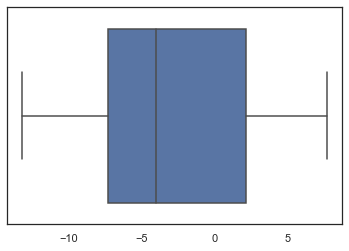

In [64]:
ax = sns.boxplot(x=featuredata[:,0,:])
if dataPre[dataPre['filenames']==PATH_featureFiles[0][-12:]]['binary'].values == 0:
    print('Not tremor')
    print(PATH_featureFiles[pathIdx][-12:])
else:
    print('Tremor event')
    print(PATH_featureFiles[pathIdx][-12:])

In [67]:
PATH_featureFiles[0]

'data/feature_bag_data/feature_4_110010.npy'

In [111]:
def dataframeConcat(binary):

    concat_spectrum = []
    concat_rms = []
    concat_kurtosis = []
    concat_entropySpec=[]
    concat_entropy =[]
    for filenames in dataPre[dataPre['binary']==binary]['filenames']: 

        data =  np.load('data/feature_bag_data/'+'feature_'+filenames)
        concat_spectrum.append(data[:,0,:])
        concat_rms.append(data[:,1,:])
        concat_kurtosis.append(data[:,2,:])
        concat_entropySpec.append(data[:,3,:])
        concat_entropy.append(data[:,4,:])


    concat_spectrum = np.array(concat_spectrum)
    concat_rms = np.array(concat_rms)
    concat_kurtosis = np.array(concat_kurtosis)
    concat_entropySpec=np.array(concat_entropySpec)
    concat_entropy = np.array(concat_entropy)
    dfd = np.vstack((concat_spectrum.flatten().T, concat_rms.flatten().T,concat_kurtosis.flatten().T,concat_entropySpec.flatten().T,concat_entropy.flatten().T))
    dataframe_tremor_binary = pd.DataFrame(dfd.T , columns = ['spectrum','rms','kurtosis','entropyspec','entropy'])
    return dataframe_tremor_binary

In [112]:
noTremorFeature = dataframeConcat(0)
TremorFeature = dataframeConcat(1)

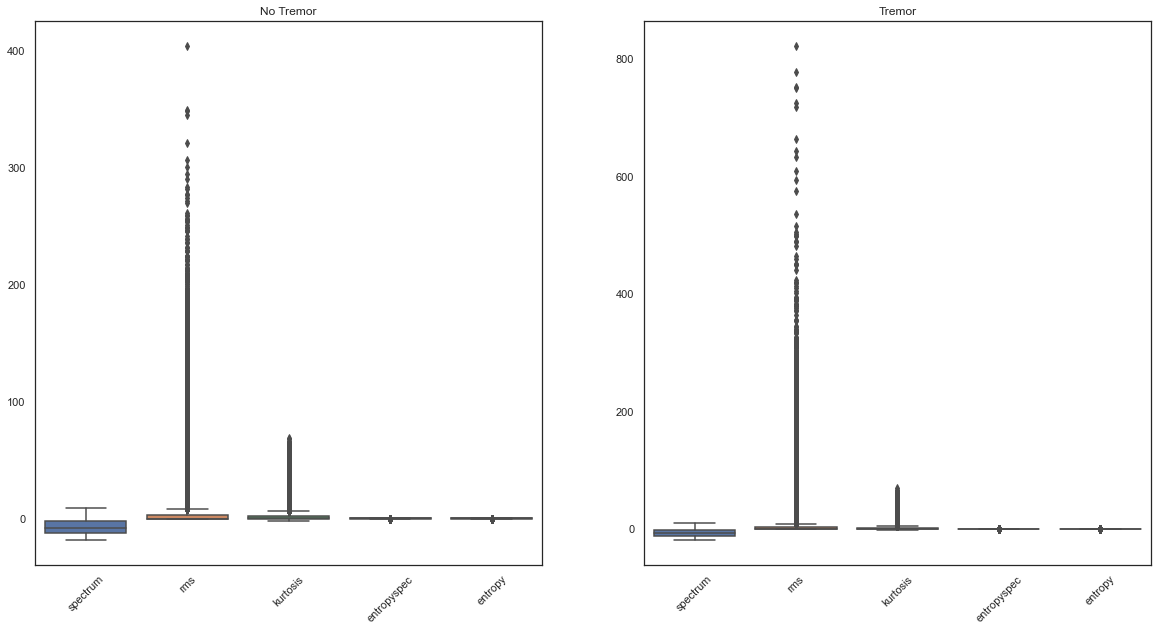

In [117]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.boxplot(data = noTremorFeature[['spectrum','rms','kurtosis','entropyspec','entropy']])
plt.xticks(rotation=45)
plt.title('No Tremor')
plt.subplot(1,2,2)
sns.boxplot(data = TremorFeature[['spectrum','rms','kurtosis','entropyspec','entropy']])
plt.xticks(rotation=45)
plt.title('Tremor')
plt.show()

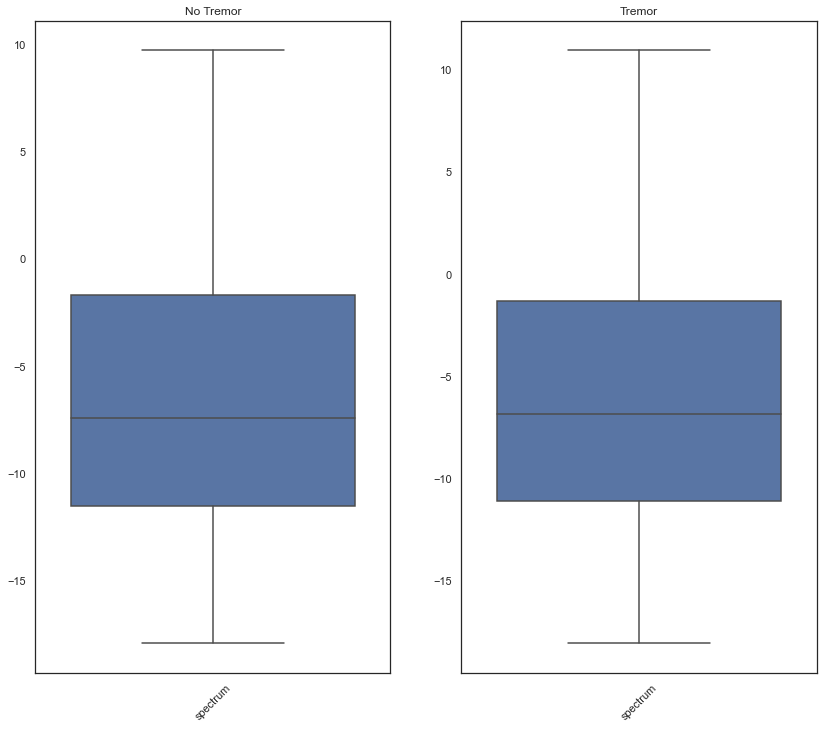

In [121]:
fig = plt.figure(figsize=(14,12))

plt.subplot(1,2,1)
sns.boxplot(data = noTremorFeature[['spectrum']])
plt.xticks(rotation=45)
plt.title('No Tremor')

plt.subplot(1,2,2)
sns.boxplot(data = TremorFeature[['spectrum']])
plt.xticks(rotation=45)
plt.title('Tremor')
plt.show()